In [5]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import requests
import nasdaqdatalink
import os
from dotenv import load_dotenv
from statsmodels.api import OLS, add_constant

# Load in Asset Data

In [6]:

# Define the asset universe
tickers = {
    # US Equities
    'SPY': 'QUOTEMEDIA/PRICES',  # S&P 500 ETF
    'QQQ': 'QUOTEMEDIA/PRICES',  # Nasdaq 100 ETF
    'IWM': 'QUOTEMEDIA/PRICES',  # Russell 2000 ETF (Small Cap)
    # International Equities
    'EFA': 'QUOTEMEDIA/PRICES',  # MSCI EAFE ETF (Developed Markets ex-US/Canada)
    'EEM': 'QUOTEMEDIA/PRICES',  # MSCI Emerging Markets ETF
    # Fixed Income
    'AGG': 'QUOTEMEDIA/PRICES',  # US Aggregate Bond ETF
    'TLT': 'QUOTEMEDIA/PRICES',  # US 20+ Year Treasury Bond ETF
    # Commodities
    'GLD': 'QUOTEMEDIA/PRICES',  # Gold ETF
    'USO': 'QUOTEMEDIA/PRICES',  # Oil ETF
    # Real Estate
    'VNQ': 'QUOTEMEDIA/PRICES',   # US Real Estate ETF
    # Adding a couple more for diversity
    'GSG': 'QUOTEMEDIA/PRICES', # Broad Commodities ETF
    'HYG': 'QUOTEMEDIA/PRICES'  # High Yield Corporate Bond ETF
}

start_date = '2010-01-01'


In [7]:
# load the data
price_df = pd.read_csv('price_data.csv', index_col=0, parse_dates=True)
price_df.head()

,SPY,QQQ,IWM,EFA,EEM,AGG,TLT,GLD,USO,VNQ,GSG,HYG
date,,,,,,,,,,,,
2010-01-04,85.431304,40.661575,52.874052,36.997067,32.075579,70.784725,59.762852,109.80,322.16,25.912552,32.70,38.596519
2010-01-05,85.657449,40.661575,52.692241,37.029675,32.308392,71.106754,60.148805,109.70,323.28,25.883469,33.03,38.779626
2010-01-06,85.717756,40.416309,52.642656,37.186194,32.375983,71.065644,59.343627,111.51,327.76,25.836937,33.27,38.879900
2010-01-07,86.079596,40.442588,53.031071,37.042718,32.188231,70.983424,59.443443,110.82,325.76,26.116130,33.11,39.036849
2010-01-08,86.366049,40.775448,53.320317,37.336191,32.443573,71.024534,59.416825,111.37,327.44,25.924185,33.18,39.097885


In [8]:
# Resample to monthly frequency (end of month) and calculate returns
if 'price_df' in locals() and not price_df.empty:
    # Forward fill to handle missing values before resampling, then backfill
    price_df_filled = price_df.ffill().bfill()
    
    # Resample to monthly frequency, taking the last available price in the month
    monthly_prices = price_df_filled.resample('ME').last()
    
    # Calculate monthly returns
    monthly_returns = monthly_prices.pct_change()
    
    # Drop the first row of NaNs resulting from pct_change()
    monthly_returns = monthly_returns.dropna(how='all', axis=0)

else:
    print("price_df is not available or empty. Cannot calculate monthly returns.")

In [9]:
# Standardize the monthly returns by their volatility
if 'monthly_returns' in locals() and not monthly_returns.empty:
    # Calculate the standard deviation for each asset's monthly returns
    returns_std = monthly_returns.std()
    
    # Standardize the returns
    # Avoid dividing by zero if any asset has zero standard deviation (e.g., if all returns are the same or NaN)
    standardized_monthly_returns = monthly_returns.copy()
    for col in standardized_monthly_returns.columns:
        if returns_std[col] != 0:
            standardized_monthly_returns[col] = standardized_monthly_returns[col] / returns_std[col]
        else:
            print(f"Warning: Standard deviation for {col} is 0. Standardized returns for this asset will be set to 0 or NaN depending on original values.")
            if monthly_returns[col].notna().all() and (monthly_returns[col] == 0).all():
                 standardized_monthly_returns[col] = 0 # All returns were 0
            else:
                 standardized_monthly_returns[col] = np.nan # Or handle as appropriate for other zero std cases
else:
    print("monthly_returns DataFrame is not available or empty. Cannot standardize returns.")

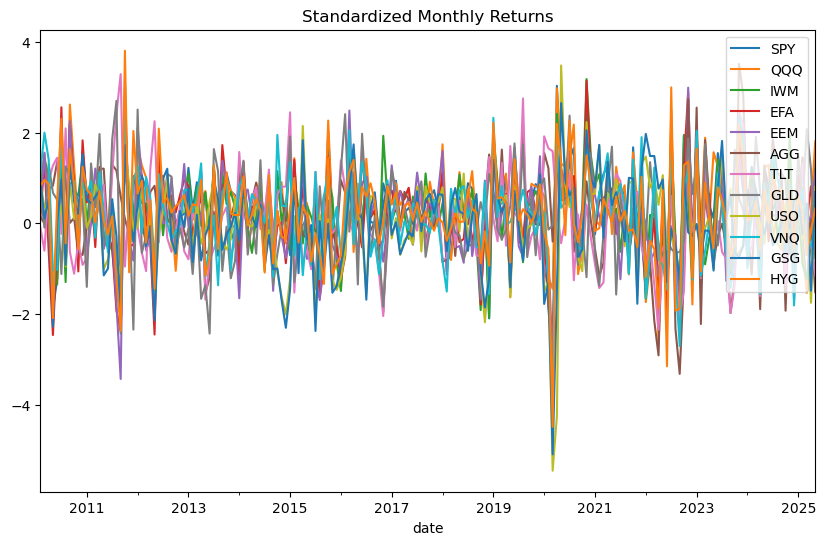

In [10]:
standardized_monthly_returns.plot(figsize= (10, 6), title = "Standardized Monthly Returns")
plt.legend(loc='upper right')
plt.show()


In [11]:
standardized_monthly_returns.head()

,SPY,QQQ,IWM,EFA,EEM,AGG,TLT,GLD,USO,VNQ,GSG,HYG
date,,,,,,,,,,,,
2010-02-28,0.744651,0.915325,0.780070,0.058765,0.340780,0.152268,-0.084553,0.720622,0.878449,1.095138,0.992441,0.837022
2010-03-31,1.453791,1.533400,1.435894,1.406601,1.557216,-0.005475,-0.605588,-0.096522,0.372811,1.997745,0.102908,0.955077
2010-04-30,0.369287,0.444818,0.989148,-0.617802,-0.033019,0.745341,0.926397,1.294645,0.254134,1.402509,0.527551,0.862404
2010-05-31,-1.896664,-1.468785,-1.313729,-2.465590,-1.802056,0.828936,1.273382,0.671631,-1.736796,-1.046385,-2.280718,-2.093010
2010-06-30,-1.235229,-1.224659,-1.351085,-0.456839,-0.268825,1.353701,1.444434,0.518096,-0.022850,-1.018626,0.012081,0.498941


# Load in Macro Data

In [12]:
FILE1             = "../data/Assignment_2_data.xlsm"

fed = pd.read_excel(FILE1, sheet_name='FF', index_col='Date')
fed.rename(columns={'Rate': 'ff'}, inplace=True)
fed = fed[~fed.index.duplicated(keep='last')]

fed = (fed            # daily EFFR
           .resample('ME').mean())   # trim to asset window

# select only >2010
fed = fed[fed.index >= '2008-01-01']
fed['rate_change_1m'] = fed['ff'].diff()

In [13]:
fed.head()

,ff,rate_change_1m
Date,,
2008-01-31,3.931429,NaN
2008-02-29,2.962500,-0.968929
2008-03-31,2.602857,-0.359643
2008-04-30,2.267727,-0.335130
2008-05-31,1.993333,-0.274394


<Axes: xlabel='Date'>

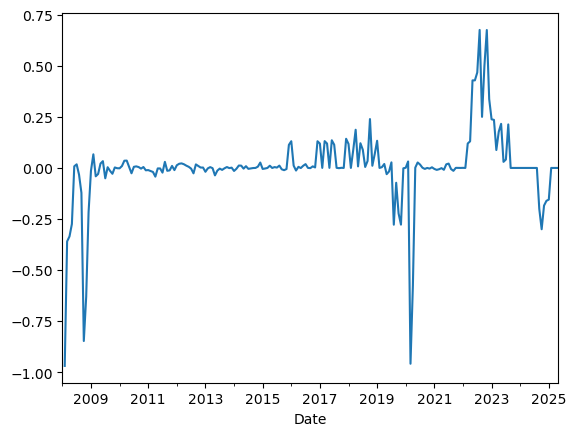

In [14]:
fed['rate_change_1m'].plot()

<Axes: xlabel='Date'>

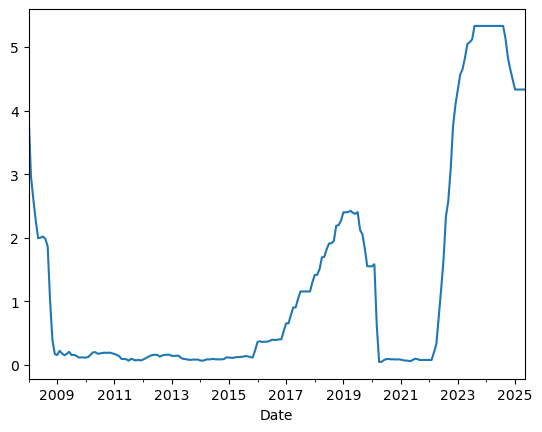

In [15]:
fed['ff'].plot()

In [16]:
ism = pd.read_excel(FILE1, sheet_name='ISM', index_col='Date')
ism = ism[~ism.index.duplicated(keep='last')]
ism = ism[ism.index >= '2010-01-01']
ism


,ISM
Date,
2010-01-31,56.3
2010-02-28,55.5
2010-03-31,58.8
2010-04-30,58.1
2010-05-31,57.4
...,...
2024-12-31,49.2
2025-01-31,50.9
2025-02-28,50.3


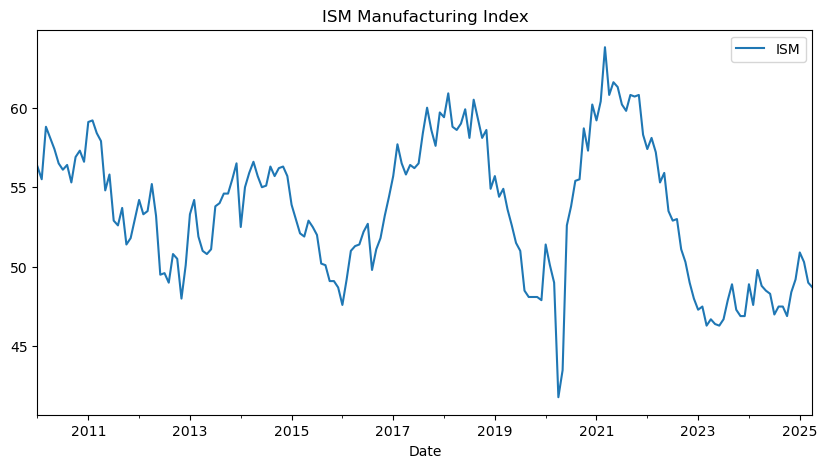

In [17]:
ism.plot(figsize = (10, 5))
plt.title("ISM Manufacturing Index")
plt.show()

In [18]:
nfp = pd.read_csv("../data/nonfarm_payrolls.csv", index_col = "observation_date")
nfp.index = pd.to_datetime(nfp.index)
nfp.rename(columns = {"PAYEMS": "nfp"}, inplace = True)
nfp.index.name = "Date"
nfp = nfp.resample('ME').mean()
nfp.head()

,nfp
Date,
2010-01-31,129802.0
2010-02-28,129705.0
2010-03-31,129865.0
2010-04-30,130120.0
2010-05-31,130643.0


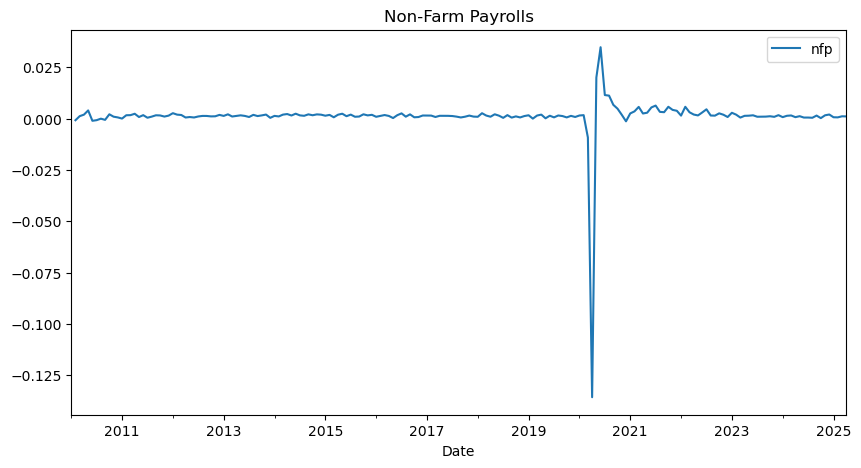

In [19]:
nfp.pct_change().plot(figsize = (10, 5))
plt.title("Non-Farm Payrolls")
plt.show()

In [20]:
pce = pd.read_csv("../data/core_pce.csv", index_col = "observation_date")
pce.index = pd.to_datetime(pce.index)
pce.rename(columns = {"PCEPILFE": "pce"}, inplace = True)
pce['pce_yoy'] = pce['pce'].pct_change(periods = 12)
pce.index.name = "Date"
pce = pce.resample("ME").mean()
pce

,pce,pce_yoy
Date,,
2008-11-30,87.952,NaN
2008-12-31,87.909,NaN
2009-01-31,87.882,NaN
2009-02-28,87.952,NaN
2009-03-31,88.015,NaN
...,...,...
2024-11-30,123.716,0.028319
2024-12-31,123.980,0.028641
2025-01-31,124.398,0.026996


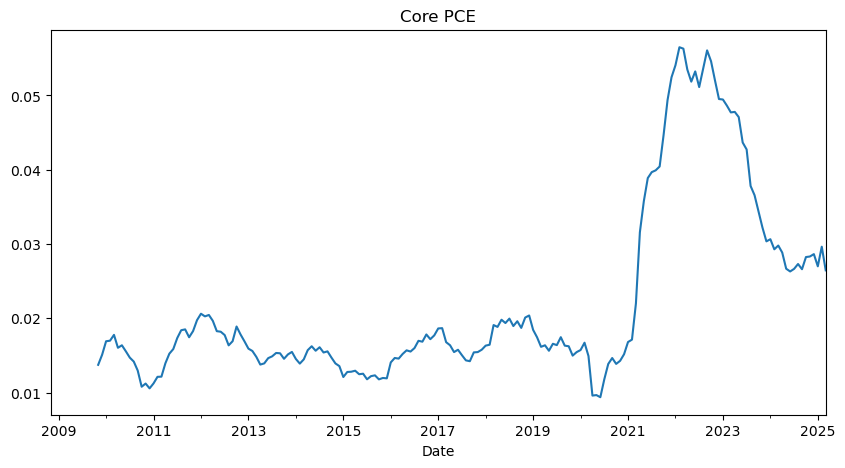

In [21]:
pce.pce_yoy.plot(figsize = (10, 5))
plt.title("Core PCE")
plt.show()

In [22]:
macro_factors = pd.concat([fed, ism, nfp, pce], axis = 1)
macro_factors
# macro_factors.columns = ['fed', 'ism', 'nfp', 'pce', 'cpi']
macro_factors


,ff,rate_change_1m,ISM,nfp,pce,pce_yoy
Date,,,,,,
2008-01-31,3.931429,NaN,NaN,NaN,NaN,NaN
2008-02-29,2.962500,-0.968929,NaN,NaN,NaN,NaN
2008-03-31,2.602857,-0.359643,NaN,NaN,NaN,NaN
2008-04-30,2.267727,-0.335130,NaN,NaN,NaN,NaN
2008-05-31,1.993333,-0.274394,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2025-01-31,4.330000,-0.154762,50.9,159053.0,124.398,0.026996
2025-02-28,4.330000,0.000000,50.3,159155.0,125.017,0.029641
2025-03-31,4.330000,0.000000,49.0,159340.0,125.052,0.026455


In [23]:
all_data = pd.merge(standardized_monthly_returns, macro_factors, left_index =True, right_index = True)
all_data.dropna(inplace = True)
all_data.head()

,SPY,QQQ,IWM,EFA,EEM,AGG,TLT,GLD,USO,VNQ,GSG,HYG,ff,rate_change_1m,ISM,nfp,pce,pce_yoy
2010-02-28,0.744651,0.915325,0.780070,0.058765,0.340780,0.152268,-0.084553,0.720622,0.878449,1.095138,0.992441,0.837022,0.126316,0.009474,55.5,129705.0,89.446,0.016987
2010-03-31,1.453791,1.533400,1.435894,1.406601,1.557216,-0.005475,-0.605588,-0.096522,0.372811,1.997745,0.102908,0.955077,0.161739,0.035423,58.8,129865.0,89.579,0.017770
2010-04-30,0.369287,0.444818,0.989148,-0.617802,-0.033019,0.745341,0.926397,1.294645,0.254134,1.402509,0.527551,0.862404,0.197727,0.035988,58.1,130120.0,89.625,0.016030
2010-05-31,-1.896664,-1.468785,-1.313729,-2.465590,-1.802056,0.828936,1.273382,0.671631,-1.736796,-1.046385,-2.280718,-2.093010,0.202500,0.004773,57.4,130643.0,89.724,0.016369
2010-06-30,-1.235229,-1.224659,-1.351085,-0.456839,-0.268825,1.353701,1.444434,0.518096,-0.022850,-1.018626,0.012081,0.498941,0.176364,-0.026136,56.5,130509.0,89.767,0.015556


## Build out factor model using ISM and PCE

In [24]:
oos = all_data[all_data.index >= "2025-01-01"]
in_sample = all_data[all_data.index < "2025-01-01"]

In [25]:
in_sample.columns

Index(['SPY', 'QQQ', 'IWM', 'EFA', 'EEM', 'AGG', 'TLT', 'GLD', 'USO', 'VNQ',
       'GSG', 'HYG', 'ff', 'rate_change_1m', 'ISM', 'nfp', 'pce', 'pce_yoy'],
      dtype='object')

In [26]:
assets = ['SPY', 'QQQ', 'IWM', 'EFA', 'EEM', 'AGG', 'TLT', 'GLD', 'USO', 'VNQ',
       'GSG', 'HYG']

results = pd.DataFrame()
for asset in assets:
    spy_model = OLS(in_sample[asset], add_constant(in_sample[['rate_change_1m', 'ISM', 'pce_yoy']])).fit()
    y_pred = spy_model.predict(add_constant(oos[['rate_change_1m', 'ISM', 'pce_yoy']]))
    y_actual = oos[asset]

    res = pd.DataFrame({'residual': sum(y_actual - y_pred), 
                        'rsquared': spy_model.rsquared,
                        'ff_pval': spy_model.pvalues['rate_change_1m'],
                        'ism_pval': spy_model.pvalues['ISM'],
                        'pce_pval': spy_model.pvalues['pce_yoy']}, index = [asset])
    results = pd.concat([results,  res], axis = 0)

results



,residual,rsquared,ff_pval,ism_pval,pce_pval
SPY,-1.760278,0.011429,0.459645,0.589742,0.166995
QQQ,-2.593529,0.018550,0.984566,0.375160,0.150926
IWM,-1.803052,0.032086,0.100418,0.761878,0.021097
EFA,1.760643,0.034107,0.025641,0.426734,0.050274
EEM,1.086597,0.040388,0.030316,0.473731,0.014954
AGG,1.302966,0.071843,0.487096,0.061684,0.001487
TLT,0.832881,0.034263,0.491137,0.456429,0.094395
GLD,3.258562,0.014163,0.579461,0.173697,0.876478
USO,0.961734,0.085829,0.002378,0.113040,0.998086
VNQ,0.337100,0.025900,0.171627,0.630055,0.058891


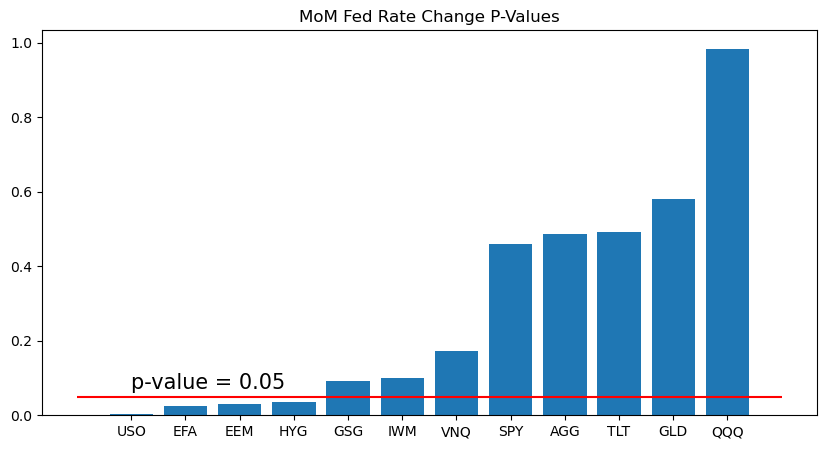

In [27]:
ff_pval = results['ff_pval'].sort_values()
plt.figure(figsize = (10, 5))
plt.bar(ff_pval.index, ff_pval.values)
plt.hlines((0.05), xmin = -1, xmax = len(results.index), color = 'red')
plt.annotate("p-value = 0.05", xy = (0, 0.05), xytext = (0, 0.07), size = 15)
plt.title("MoM Fed Rate Change P-Values")
plt.show()

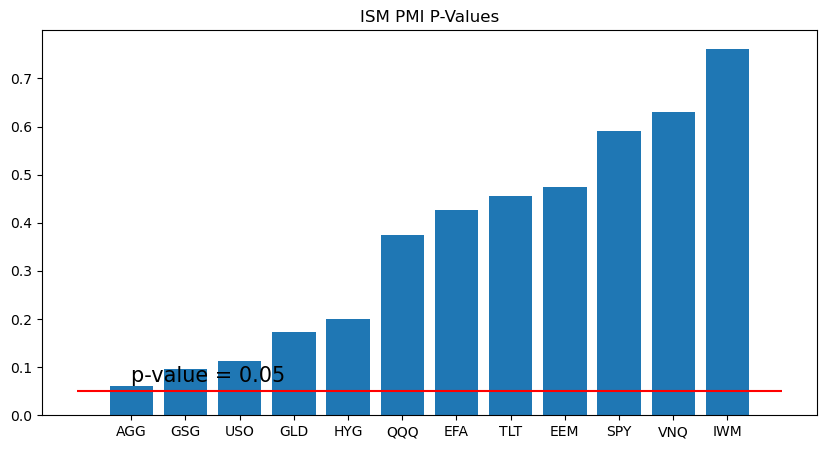

In [28]:
ism_pval = results['ism_pval'].sort_values()
plt.figure(figsize = (10, 5))
plt.bar(ism_pval.index, ism_pval.values)
plt.hlines((0.05), xmin = -1, xmax = len(results.index), color = 'red')
plt.annotate("p-value = 0.05", xy = (0, 0.05), xytext = (0, 0.07), size = 15)
plt.title("ISM PMI P-Values")
plt.show()

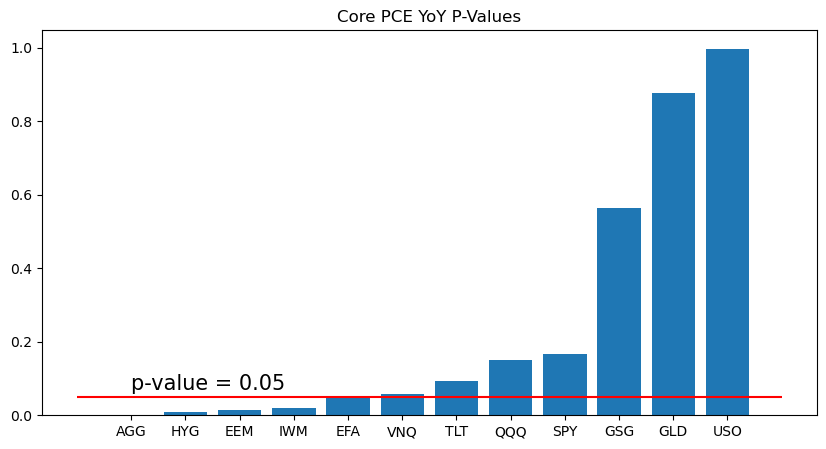

In [29]:
pce_pval = results['pce_pval'].sort_values()
plt.figure(figsize = (10, 5))
plt.bar(pce_pval.index, pce_pval.values)
plt.hlines((0.05), xmin = -1, xmax = len(results.index), color = 'red')
plt.annotate("p-value = 0.05", xy = (0, 0.05), xytext = (0, 0.07), size = 15)
plt.title("Core PCE YoY P-Values")
plt.show()

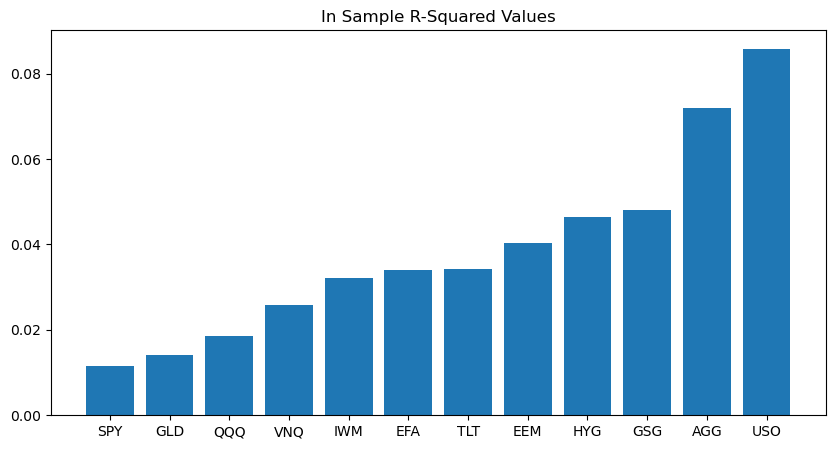

In [30]:
r2 = results['rsquared'].sort_values()
plt.figure(figsize = (10, 5))
plt.bar(r2.index, r2.values)
plt.title("In Sample R-Squared Values")
plt.show()

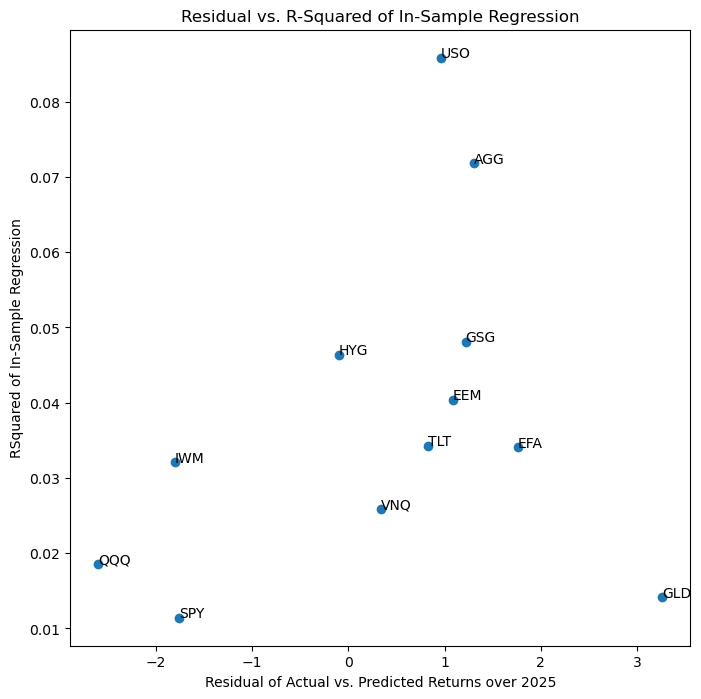

In [31]:
fig, ax = plt.subplots(figsize = (8, 8))
ax.scatter(results['residual'], results['rsquared'])
for asset, (x, y) in results[['residual', 'rsquared']].iterrows():
    ax.annotate(asset, (x, y), fontsize = 10)
ax.set_xlabel("Residual of Actual vs. Predicted Returns over 2025")
ax.set_ylabel("RSquared of In-Sample Regression")
ax.set_title("Residual vs. R-Squared of In-Sample Regression")
plt.show()

How to decide if they are significant?
Can do either p-value or r-squared.

Run a regression for each, pull out p-values and r-squared, also use the model to forecast the next month then move to the next asset.

In [32]:
assets = ['SPY', 'QQQ', 'IWM', 'EFA', 'EEM', 'AGG', 'TLT', 'GLD', 'USO', 'VNQ',
       'GSG', 'HYG']

rm_covid = in_sample[(in_sample.index <= "2020-01-01" )| (in_sample.index >= "2021-01-01")]
rm_covid_results = pd.DataFrame()
for asset in assets:
    spy_model = OLS(rm_covid[asset], add_constant(rm_covid[['rate_change_1m', 'ISM', 'pce_yoy']])).fit()
    y_pred = spy_model.predict(add_constant(oos[['rate_change_1m', 'ISM', 'pce_yoy']]))
    y_actual = oos[asset]

    res = pd.DataFrame({'residual': sum(y_actual - y_pred), 
                        'rsquared': spy_model.rsquared,
                        'ff_pval': spy_model.pvalues['rate_change_1m'],
                        'ism_pval': spy_model.pvalues['ISM'],
                        'pce_pval': spy_model.pvalues['pce_yoy']}, index = [asset])
    rm_covid_results = pd.concat([rm_covid_results,  res], axis = 0)

rm_covid_results

,residual,rsquared,ff_pval,ism_pval,pce_pval
SPY,-1.944781,0.007447,0.687157,0.801202,0.514974
QQQ,-2.614225,0.012766,0.594862,0.610688,0.414955
IWM,-2.059131,0.016544,0.875055,0.807560,0.139667
EFA,1.567744,0.013161,0.322005,0.443047,0.189818
EEM,0.916047,0.018881,0.336626,0.468650,0.089302
AGG,1.358951,0.061819,0.634241,0.136465,0.004868
TLT,1.013954,0.028741,0.984875,0.574704,0.067354
GLD,3.303938,0.010412,0.582495,0.276689,0.673748
USO,0.006010,0.044168,0.101685,0.090029,0.020279
VNQ,-0.012071,0.018446,0.733713,0.505945,0.276304


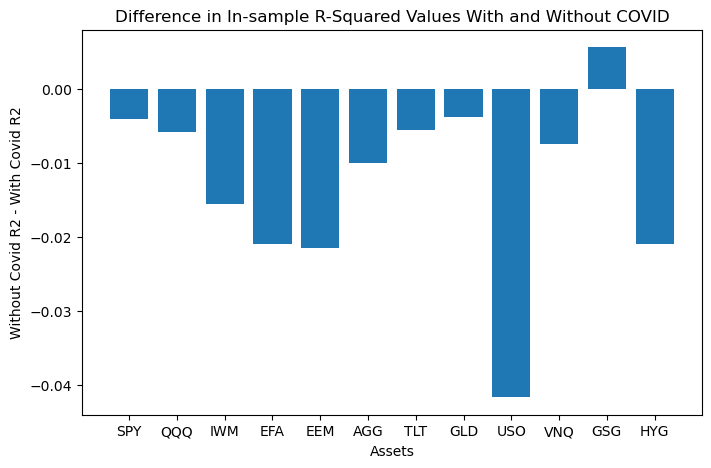

In [33]:
plt.figure(figsize = (8, 5))
plt.bar(rm_covid_results.index, rm_covid_results['rsquared'] - results['rsquared'])
plt.title("Difference in In-sample R-Squared Values With and Without COVID")
plt.xlabel("Assets")
plt.ylabel("Without Covid R2 - With Covid R2")
plt.show()

In [34]:
from sklearn.decomposition import PCA
from scipy import stats
import statsmodels.api as sm

In [35]:
def get_daily_standardized_returns(price_df):
    """
    Convert price dataframe to daily standardized returns.

    Parameters:
    price_df (pd.DataFrame): DataFrame containing price data for multiple assets

    Returns:
    pd.DataFrame: DataFrame containing standardized daily returns
    """
    if not isinstance(price_df, pd.DataFrame) or price_df.empty:
        print("price_df is not available or empty. Cannot calculate daily returns.")
        return None

    # Forward fill to handle missing values before calculating returns, then backfill
    price_df_filled = price_df.ffill().bfill()

    # Calculate daily returns (no need to resample since data is already daily)
    daily_returns = price_df_filled.pct_change()

    # Drop the first row of NaNs resulting from pct_change()
    daily_returns = daily_returns.dropna(how='all', axis=0)

    # Calculate the standard deviation for each asset's daily returns
    returns_std = daily_returns.std()

    # Standardize the returns
    standardized_daily_returns = daily_returns.copy()

    for col in standardized_daily_returns.columns:
        if returns_std[col] != 0:
            standardized_daily_returns[col] = standardized_daily_returns[col] / returns_std[col]
        else:
            print(
                f"Warning: Standard deviation for {col} is 0. Standardized returns for this asset will be set to 0 or NaN depending on original values.")

            if daily_returns[col].notna().all() and (daily_returns[col] == 0).all():
                standardized_daily_returns[col] = 0  # All returns were 0
            else:
                standardized_daily_returns[col] = np.nan  # Handle zero std cases

    return standardized_daily_returns

In [36]:
standardized_daily_returns = get_daily_standardized_returns(price_df)

In [37]:
standardized_daily_returns.head()

,SPY,QQQ,IWM,EFA,EEM,AGG,TLT,GLD,USO,VNQ,GSG,HYG
date,,,,,,,,,,,,
2010-01-05,0.241322,0.000000,-0.243288,0.075217,0.533999,1.514750,0.672594,-0.092431,0.155577,-0.085713,0.759214,0.887555
2010-01-06,0.064185,-0.459073,-0.066580,0.360723,0.153915,-0.192497,-1.394167,1.674531,0.620151,-0.137295,0.546639,0.483747
2010-01-07,0.384833,0.049485,0.522036,-0.329271,-0.426649,-0.385216,0.175176,-0.627995,-0.273069,0.825254,-0.361797,0.755217
2010-01-08,0.303376,0.626401,0.385903,0.676118,0.583627,0.192831,-0.046635,0.503693,0.230786,-0.561297,0.159051,0.292515
2010-01-11,0.127316,-0.310644,-0.285116,0.700617,-0.153273,-0.256959,-0.571535,1.348698,-0.426404,0.445508,-0.362779,-0.166890


In [38]:
#10

In [39]:
estimation_end = '2024-12-31'
estimation_data = standardized_monthly_returns[standardized_monthly_returns.index <= estimation_end]
pca = PCA()
pc_scores = pca.fit_transform(estimation_data)

In [40]:
pc_df = pd.DataFrame(
    pc_scores,
    index=estimation_data.index,
    columns=[f'PC{i+1}' for i in range(len(estimation_data.columns))]
)
pc_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
date,,,,,,,,,,,,
2010-02-28,1.674596,-0.428669,0.687425,-0.221664,-0.813888,0.016565,-0.067077,-0.066949,-0.485370,0.105900,-0.016684,-0.102654
2010-03-31,3.222678,-0.270232,-1.051252,0.422906,-0.072141,-0.700128,-0.606330,-0.328151,-0.234949,0.147450,-0.338560,-0.105911
2010-04-30,1.048135,1.038904,1.040441,-0.334502,-1.413518,-0.291075,-0.019725,0.400115,-0.621310,-0.029322,0.079900,-0.161536
2010-05-31,-5.561872,2.284588,0.389821,0.209802,-0.542442,-0.004955,-0.403966,0.587995,-0.088433,0.472794,-0.289989,0.122664
2010-06-30,-2.050370,1.286083,1.929189,-0.954002,1.111507,-0.183207,0.823954,0.135745,0.065375,-0.138595,0.111125,-0.068015


In [41]:
#11

In [42]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=estimation_data.columns,
    columns=[f'PC{i+1}' for i in range(len(estimation_data.columns))]
)

In [43]:
explained_variance = pca.explained_variance_ratio_ * 100

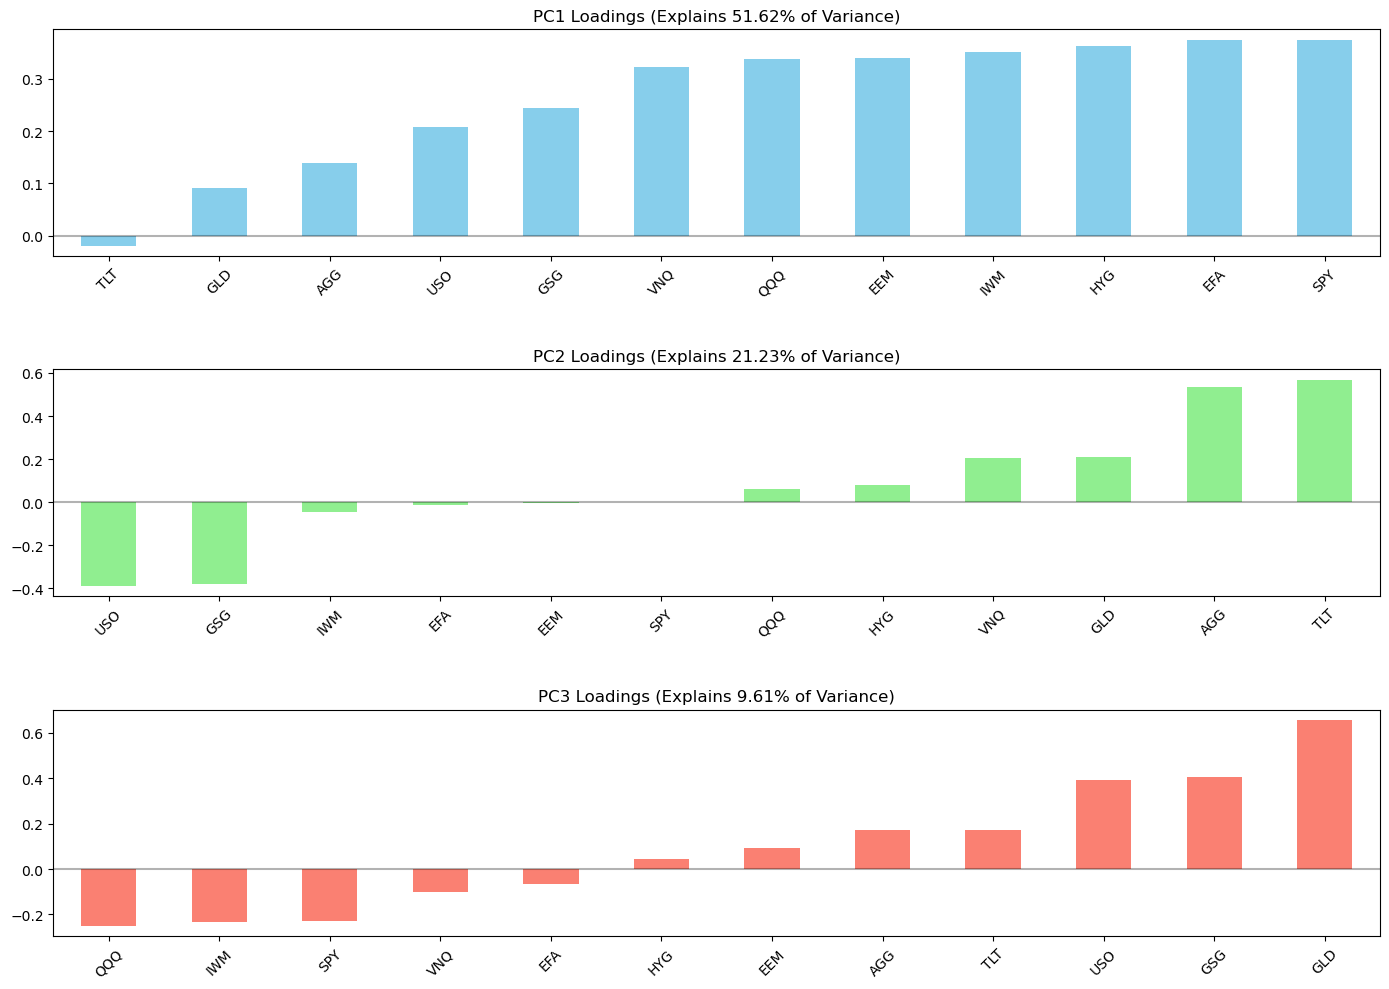

In [44]:
plt.figure(figsize=(14, 10))

# PC1 loadings
plt.subplot(3, 1, 1)
loadings['PC1'].sort_values().plot(kind='bar', color='skyblue')
plt.title(f'PC1 Loadings (Explains {explained_variance[0]:.2f}% of Variance)')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

# PC2 loadings
plt.subplot(3, 1, 2)
loadings['PC2'].sort_values().plot(kind='bar', color='lightgreen')
plt.title(f'PC2 Loadings (Explains {explained_variance[1]:.2f}% of Variance)')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

# PC3 loadings
plt.subplot(3, 1, 3)
loadings['PC3'].sort_values().plot(kind='bar', color='salmon')
plt.title(f'PC3 Loadings (Explains {explained_variance[2]:.2f}% of Variance)')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

plt.subplots_adjust(hspace=0.5)
plt.show()

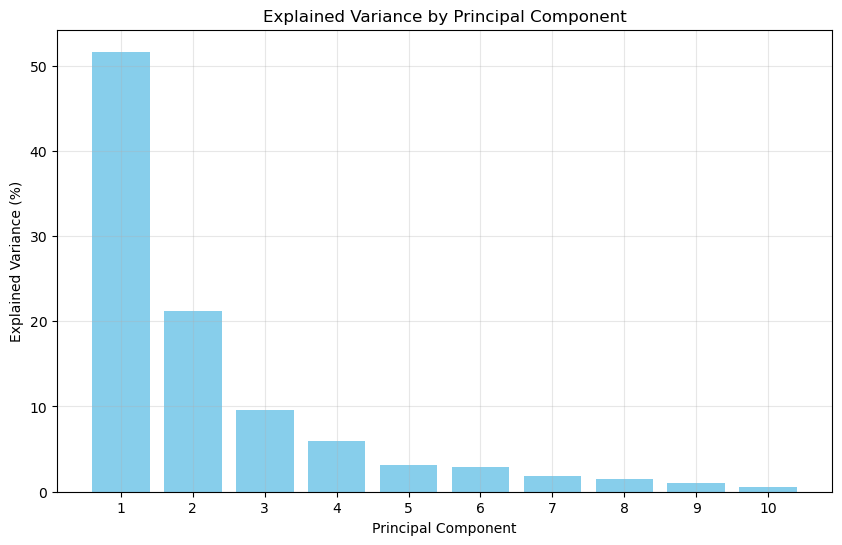

In [45]:
plt.figure(figsize=(10, 6))
plt.bar(range(1, min(10, len(explained_variance))+1), explained_variance[:10], color='skyblue')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.title('Explained Variance by Principal Component')
plt.xticks(range(1, min(10, len(explained_variance))+1))
plt.grid(True, alpha=0.3)
plt.show()

In [46]:
#12

In [47]:
estimation_end = '2024-12-31'
oos_start = '2025-01-01'

In [48]:
in_sample_data = standardized_monthly_returns[standardized_monthly_returns.index <= estimation_end]
out_sample_data = standardized_monthly_returns[standardized_monthly_returns.index >= oos_start]

In [49]:
pca = PCA()
pc_scores_in = pca.fit_transform(in_sample_data)

In [50]:
pc_df_in = pd.DataFrame(
    pc_scores_in,
    index=in_sample_data.index,
    columns=[f'PC{i+1}' for i in range(len(in_sample_data.columns))]
)

In [51]:
pc_scores_out = pca.transform(out_sample_data)
pc_df_out = pd.DataFrame(
    pc_scores_out,
    index=out_sample_data.index,
    columns=[f'PC{i+1}' for i in range(len(out_sample_data.columns))]
)

In [52]:
pc_df_out

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
date,,,,,,,,,,,,
2025-01-31,1.300388,0.150841,1.121733,0.626348,-0.098194,0.037249,0.090708,-0.079175,0.620791,-0.089651,0.054173,-0.018661
2025-02-28,-0.395119,1.810643,0.915335,-0.635497,0.757702,-0.710686,-0.149845,-0.675990,0.421979,0.050871,0.175549,0.013621
2025-03-31,-2.033380,-0.621137,2.672991,1.086459,0.460063,-0.876699,-0.184332,-0.226867,0.557896,0.145526,-0.019356,-0.149230
2025-04-30,-1.123957,1.007231,-0.417638,2.114269,0.475613,-0.144657,0.393737,-0.342787,0.807993,0.212860,-0.156218,-0.296521
2025-05-31,1.675775,-2.360108,-1.202037,0.538290,0.222958,0.809256,-0.387138,0.217016,-0.749356,-0.428842,-0.112541,0.008902


In [53]:
regression_results = {}
predictions = {}
residuals = {}
r_squared = {}
betas_to_pc1 = {}

In [54]:
import warnings
warnings.filterwarnings('ignore')
for asset in in_sample_data.columns:
    # Prepare the data for full model (PC1, PC2, PC3)
    y = in_sample_data[asset]
    X = sm.add_constant(pc_df_in[['PC1', 'PC2', 'PC3']])

    # Fit the model
    model = sm.OLS(y, X).fit()
    regression_results[asset] = model
    r_squared[asset] = model.rsquared

    # Calculate beta to PC1 specifically
    X_pc1 = sm.add_constant(pc_df_in['PC1'])
    model_pc1 = sm.OLS(y, X_pc1).fit()
    betas_to_pc1[asset] = model_pc1.params[1]  # Skip the constant term

    # Predict out-of-sample returns using the fitted model
    X_oos = sm.add_constant(pc_df_out[['PC1', 'PC2', 'PC3']])
    predictions[asset] = model.predict(X_oos)

    # Calculate residuals (actual - predicted)
    residuals[asset] = out_sample_data[asset] - predictions[asset]

In [55]:
predictions_df = pd.DataFrame(predictions, index=out_sample_data.index)
residuals_df = pd.DataFrame(residuals, index=out_sample_data.index)
avg_residuals = residuals_df.mean()
r_squared_series = pd.Series(r_squared)
betas_series = pd.Series(betas_to_pc1)

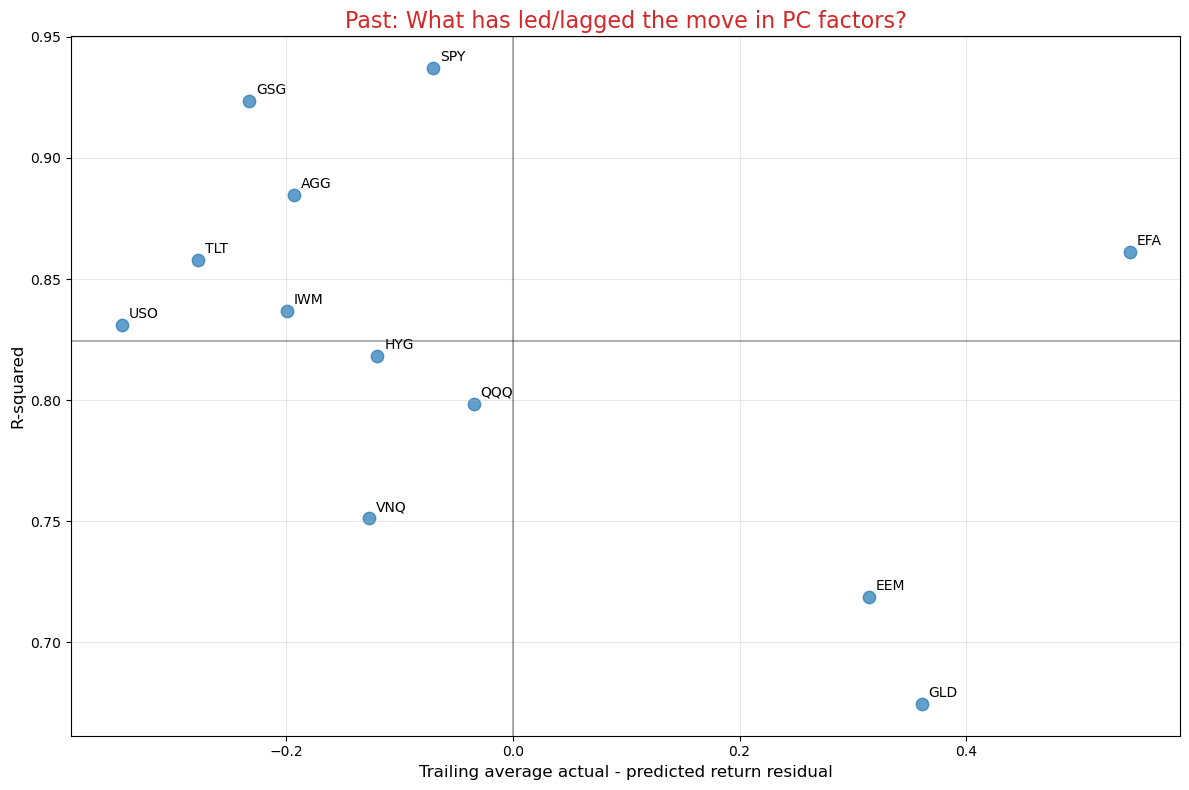

In [56]:
plt.figure(figsize=(12, 8))
plt.scatter(avg_residuals, r_squared_series, s=80, alpha=0.7)

# Add asset labels
for i, asset in enumerate(avg_residuals.index):
    plt.annotate(asset, (avg_residuals[i], r_squared_series[i]),
                xytext=(5, 5), textcoords='offset points')

plt.axhline(y=np.mean(r_squared_series), color='black', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.title('Past: What has led/lagged the move in PC factors?', fontsize=16, color='#d62728')
plt.xlabel('Trailing average actual - predicted return residual', fontsize=12)
plt.ylabel('R-squared', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

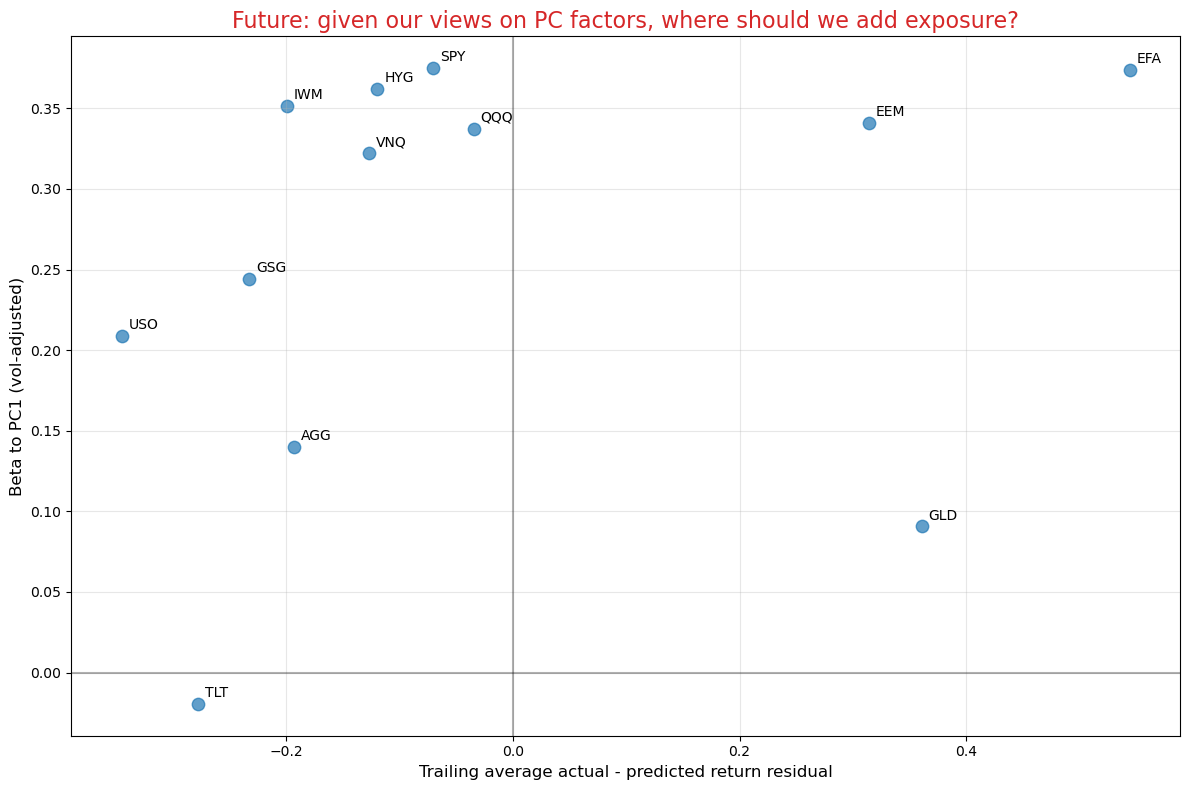

In [57]:
plt.figure(figsize=(12, 8))

# Create scatter plot
plt.scatter(avg_residuals, betas_series, s=80, alpha=0.7)

# Add asset labels
for i, asset in enumerate(avg_residuals.index):
    plt.annotate(asset, (avg_residuals[i], betas_series[i]),
                xytext=(5, 5), textcoords='offset points')

plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.title('Future: given our views on PC factors, where should we add exposure?',
          fontsize=16, color='#d62728')
plt.xlabel('Trailing average actual - predicted return residual', fontsize=12)
plt.ylabel('Beta to PC1 (vol-adjusted)', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [58]:
std_errors = residuals_df.std() / np.sqrt(len(residuals_df))
t_stats = avg_residuals / std_errors
p_values = [2 * (1 - stats.t.cdf(abs(t), len(residuals_df) - 1)) for t in t_stats]

In [59]:
results_summary = pd.DataFrame({
    'Avg Residual': avg_residuals,
    'Std Error': std_errors,
    't-stat': t_stats,
    'p-value': p_values,
    'R-squared': pd.Series(r_squared)
})

In [60]:
results_summary = results_summary.sort_values('Avg Residual', ascending=False)

Assets LEADING the broader cross-asset performance (positive residuals):

In [61]:
for asset in results_summary.head(3).index:
    p_val = results_summary.loc[asset, 'p-value']
    sig_marker = '*' if p_val < 0.1 else ''
    print(f"- {asset}: +{results_summary.loc[asset, 'Avg Residual']:.3f} std dev {sig_marker}")
    print(f"  (t-stat: {results_summary.loc[asset, 't-stat']:.2f}, p-value: {results_summary.loc[asset, 'p-value']:.3f})")


- EFA: +0.544 std dev 
  (t-stat: 1.95, p-value: 0.123)
- GLD: +0.361 std dev 
  (t-stat: 1.18, p-value: 0.304)
- EEM: +0.314 std dev *
  (t-stat: 2.14, p-value: 0.099)


Assets LAGGING the broader cross-asset performance (negative residuals)


In [62]:
for asset in results_summary.tail(3).index:
    p_val = results_summary.loc[asset, 'p-value']
    sig_marker = '*' if p_val < 0.1 else ''
    print(f"- {asset}: {results_summary.loc[asset, 'Avg Residual']:.3f} std dev {sig_marker}")
    print(f"  (t-stat: {results_summary.loc[asset, 't-stat']:.2f}, p-value: {results_summary.loc[asset, 'p-value']:.3f})")


- GSG: -0.233 std dev 
  (t-stat: -1.68, p-value: 0.169)
- TLT: -0.278 std dev 
  (t-stat: -1.15, p-value: 0.315)
- USO: -0.345 std dev 
  (t-stat: -1.80, p-value: 0.147)
